# An Intuitive Guide to Bayesian Hilbert Maps

### Ransalu Senanayake

Reference paper,
```
@inproceedings{senanayake2017bayesian,
  title={Bayesian hilbert maps for dynamic continuous occupancy mapping},
  author={Senanayake, Ransalu and Ramos, Fabio},
  booktitle={Conference on Robot Learning (CoRL)},
  pages={458--471},
  year={2017}
}
```

Given a set of LIDAR reflections, we want to build an occupancy map of the environemnt. An occupancy map indicates which areas of the environment are occupied and which areas are free. Essentially, this is a classification problem. However, the boundary between the two classes---occupied and free---is highly nonlinear. Therefore, we can think of using a deep neural network or a kernel based classification method. Since there are only a very few data points, it is challenging to use a frequentist deep neural network. Thererefore, Gaussian process classification models which are known to modeling spatial processes would be ideal. Unfortunately, Gaussian processes are extremely slow to use for occupancy mapping. As a sophisticated alternative, in this tutorial, we discuss Bayesian Hilbert maps as a fast occupancy mapping technique that can sequentially learn occupancy maps with a limited amount of data in real-time.

**Objective:** Predict the occupancy probability of any loction in the space, given a set of LIDAR scans.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_classification

## 1. Basics of Bayesian Hilbert Maps

#### Step 1: Define hinge points

Firstly, we need to define some pseudopints in the longitude-latitude space that is being mapped. We call these *hinge points* (a.k.a. anchor points, inducing points, or kernel locations) as these will be used to hinge kernels in the next step. For the sake of simplicity, let's place nine of these hinge points $\{\tilde{\bf{x}}_m \}_{m=1}^{M=9}$ on a regular grid (see section 4 for learning hinge points).

\begin{equation}
 \{ \tilde{\mathbf{x}}_1, \tilde{\mathbf{x}}_2, ..., \tilde{\mathbf{x}}_m, ..., \tilde{\mathbf{x}}_M \}
\end{equation}

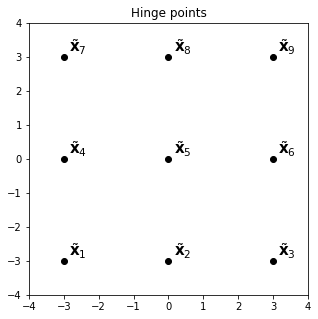

In [2]:
# Place nine hinge points on a regular grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 3), np.linspace(-3, 3, 3))
grid = np.hstack((xx.ravel().reshape(-1,1), yy.ravel().reshape(-1,1)))

#Plot
pl.figure(figsize=(5,5))
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points')
pl.xlim([-4,4])
pl.ylim([-4,4]);

#### Step 2: Compute the distances

There are two classes: occupied (class $y=1$) and free (class $y=0$). How to generate data from LIDAR will be discussed in section 3. In order to explan the concept, let's consider a datapoint that belongs to class $y=0$ in in $\mathbf{x}=(-1.6,2)$.

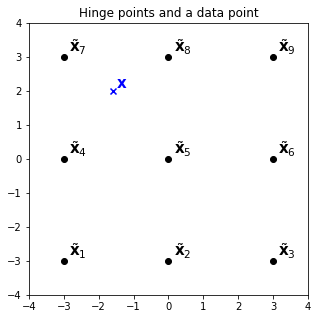

In [3]:
# Define the datapoint
X = np.array([[-1.6,2]]) 
y = np.array([0])

# Plot
pl.figure(figsize=(5,5))
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='x')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf{x}$', color='b', fontsize=15)
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points and a data point')
pl.xlim([-4,4])
pl.ylim([-4,4]);

Now, we need to know how far the datapoint $\mathbf{x}$ from each hinge point $\tilde{\mathbf{x}}$. We can use a kernel for this purpose---a kernel tells us how close two data points are. In this tutorial, we use a RBF kernel,
\begin{equation}
 k(\bf{x}, \bf{x}_m) = \exp{ \big(-\gamma \| \bf{x} - \tilde{\bf{x}}_m \|^2 \big) }
\end{equation}

Here, the parameter $\gamma$ controls the width of the bell curve (i.e. stregth of similarity between the two points). Let's visualize the effect of $\gamma$.

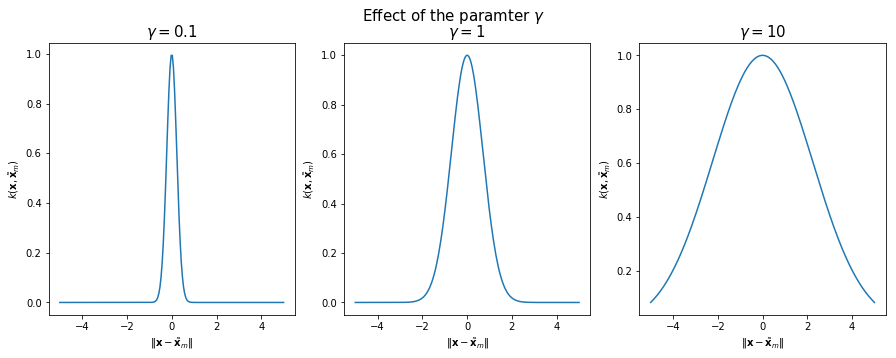

In [4]:
xTemp = np.linspace(-5,5,200)
pl.figure(figsize=(15,5))
pl.suptitle('Effect of the paramter $\gamma$', fontsize=15)
for i, gammaTemp in enumerate([0.1, 1, 10]):
    kTemp = np.exp( -1/gammaTemp * xTemp**2 ) 
    pl.subplot(1,3,i+1)
    pl.plot(xTemp, kTemp)
    pl.xlabel(r'$\Vert {\bf x} - \tilde{\bf x}_m \Vert$')
    pl.ylabel(r'$k({\bf x}, \tilde{\bf x}_m)$')
    pl.title(r'$\gamma={}$'.format(gammaTemp), fontsize=15)
pl.show()

For Bayesian Hilbert maps, $\gamma$ is an easy to tune parameter and let's consider it as $0.5$ (see section 4 for learning $\gamma$ for complex environments). Now, let's compute the kernel distance between $\bf{x}$ and all hinge points,

\begin{equation}
 \Phi(\mathbf{x}) = [k(\mathbf{x}, \tilde{\mathbf{x}}_1), k(\mathbf{x}, \tilde{\mathbf{x}}_2), \dots, k(\mathbf{x}, \tilde{\mathbf{x}}_m) \dots, k(\mathbf{x}, \tilde{\mathbf{x}}_M)] \in \mathbb{R}^{1 \times M}
\end{equation}

In this exmaple $M=9$.

Phi(x)= [[0.    0.    0.    0.051 0.038 0.    0.228 0.169 0.   ]]
Shape of Phi(x) is (1, 9)


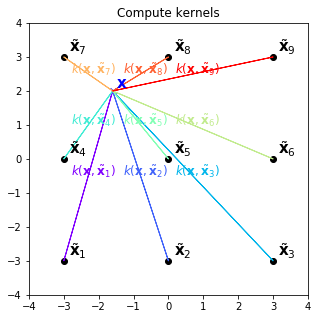

In [26]:
#Compute the kernel distance between X1 and all hinge points
Phi = rbf_kernel(X, grid, gamma=0.5)
print('Phi(x)=', np.round(Phi, 3))
print('Shape of Phi(x) is', Phi.shape)

# Plot
pl.figure(figsize=(5,5))
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='x')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf x$', color='b', fontsize=15)
color = iter(pl.cm.rainbow(np.linspace(0,1,Phi.shape[1])))
for i in range(grid.shape[0]):
    c = next(color)
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf x}$'+'$_{}$'.format(i+1), fontsize=15)
    pl.arrow(X[0,0], X[0,1], grid[i,0]-X[0,0], grid[i,1]-X[0,1], color=c)
    pl.text((grid[i,0]+X[0,0])/2-0.5, (grid[i,1]+X[0,1])/2, r'$k({\bf x},\tilde{\bf x}$'+'$_{}$)'.format(i+1), color=c, fontsize=12) 
pl.title('Compute kernels');
pl.xlim([-4,4])
pl.ylim([-4,4]);

$(-1.5,2)$ are closer to hinge points 7, 8, 4, and 5.

#### Step 3: Learn parameters

Before defining the model, let us see what a sigmodal function $\sigma(w.z):=1/\big(1+\exp(-w.z)\big)$ is. The following example shows the effect of the parameter $w$ for a one dimensional input $z$.

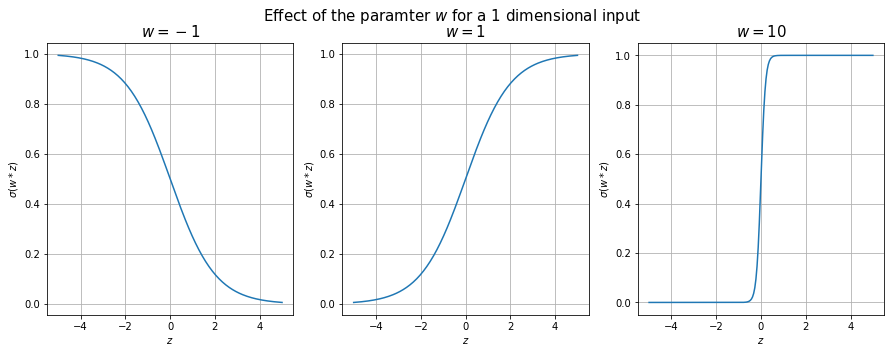

In [6]:
zTemp = np.linspace(-5,5,200)
pl.figure(figsize=(15,5))
pl.suptitle('Effect of the paramter $w$ for a 1 dimensional input', fontsize=15)
for i, wTemp in enumerate([-1, 1, 10]):
    sigmoidTemp = 1 / (1 + np.exp(-wTemp*zTemp)) 
    pl.subplot(1,3,i+1)
    pl.plot(zTemp, sigmoidTemp)
    pl.xlabel(r'$z$')
    pl.ylabel(r'$\sigma(w*z)$')
    pl.title(r'$w={}$'.format(wTemp), fontsize=15)
    pl.grid()
pl.show()

Note that the sigmoidal outputs are always between $0$ and $1$. The parameter $w$ controls show sharp the transition from $0$ to $1$ is. In Bayesian Hilbert maps, our objective is to learn the sharpness of these transitions for different locations in the environment. 

Having computed the feature vector $\Phi(\mathbf{x}) \in \mathbb{R}^{1 \times M}$ in step 2, let's now define our model,
\begin{equation}
y = \sigma \big( \mathbf{w} \Phi^\top(\mathbf{x}) \big).
\end{equation}

Here, $\mathbf{w}=[w_1, w_2, \dots, w_m, \dots, w_M] \in \mathbb{R}^{1 \times M}$ with $w_m \sim \mathcal{N}(\mu_m, \sigma_m)$ are normally distribiuited weights with mean $\mu_m$ and variance $\sigma_m$. That is, the weight vector $\mathbf{w}$ is implicitly represented by two other vectors $\boldsymbol{\mu}=[\mu_1, \mu_2, \dots, \mu_m, \dots, \mu_M] \in \mathbb{R}^{1 \times M}$ and $\boldsymbol{\sigma}=[\sigma_1, \sigma_2, \dots, \sigma_m, \dots, \sigma_M] \in \mathbb{R}^{1 \times M}$. In other words, each hinge location has an associated weight defined by mean and variance parameters.

Now, let's try to estimate $\mathbf{w}$ using the Bayes' Theorem,

\begin{equation}
    \underbrace{\mathrm{Q}(\mathbf{w})}_{\substack{\text{approx.}\\\text{posterior}}}
	\approx \underbrace{\mathrm{P}(\mathbf{w}|\mathbf{x,y})}_\text{posterior} 
    = \frac{
    	\overbrace{\mathrm{P}(\mathbf{y} \vert \mathbf{x,w})}^\text{likelihood} 
        \times 
        \overbrace{\mathrm{P}(\mathbf{w})}^\text{prior}} 
    {\underbrace{\mathrm{P}(\mathbf{y})}_\text{marginal likelihood}}
\end{equation}

Since we don't have previous knowledge about what the prior probability distributions $\mathrm{P}(\mathbf{w})$ should be, let's define them as uninformative Gaussian priors (zero mean and very high variance is equaivalent to saying, we don't know anything).

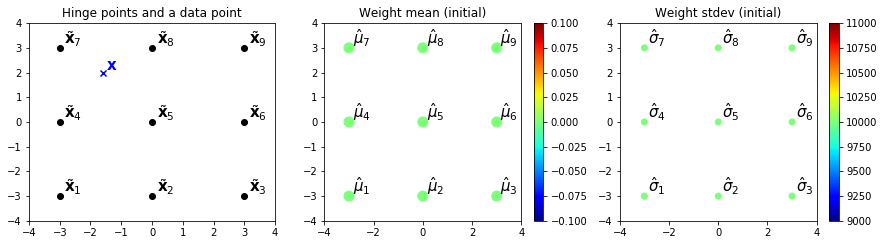

In [7]:
# Get the dimensionality
N, D = Phi.shape[0], Phi.shape[1]

# Let's define the prior distributions
mu = np.zeros(D)
sig = 10000*np.ones(D)

# Plot
pl.figure(figsize=(15,8))
pl.subplot(231)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='x')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf{x}$', color='b', fontsize=15)
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points and a data point')
pl.xlim([-4,4]); pl.ylim([-4,4])

pl.subplot(232)
pl.scatter(grid[:,0], grid[:,1], c=mu, s=100, cmap='jet'); pl.colorbar()
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\hat{\mu}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Weight mean (initial)')
pl.xlim([-4,4]); pl.ylim([-4,4]);

pl.subplot(233)
pl.scatter(grid[:,0], grid[:,1], c=sig, cmap='jet'); pl.colorbar()
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\hat{\sigma}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Weight stdev (initial)')
pl.xlim([-4,4]); pl.ylim([-4,4]);

Using this prior and the feature vector, we can compute the likelihood $\mathrm{P}(\mathbf{y} \vert \mathbf{x,w}) = \sigma \big( \mathbf{w} \Phi^\top(\mathbf{x}) \big)$. However,
because of the sigmoidal likelihood, the posterior is intractable. Therefore, we define an approximate posterior $\mathrm{Q}(\mathbf{w})$ which are also Gaussians. In order to estimate the parameters, it is also required to define a vector $\boldsymbol{\xi} \in \mathbb{R}^{N}$ that helps to perform local linear approximations. Now, we can estmate the parameters in an iteratively.

Perform iteratively:

$\quad$ E-like-step: use $\boldsymbol{\xi}$ from the M-step and estimate $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$,
\begin{equation}
\boldsymbol{\sigma}_{t+1} = \bigg( \boldsymbol{\sigma}_{t}^{-1} + 2\sum_{n=1}^{N_t} \lambda(\xi_{n,t}) \Phi(\mathbf{x}_n) \Phi^\top(\mathbf{x}_n) \big) \bigg)^{-1}
\end{equation}

\begin{equation}
\boldsymbol{\mu}_{t+1} = \boldsymbol{\sigma}_{t+1} \big( \boldsymbol{\sigma}_{t}^{-1} \boldsymbol{\mu}_{t} + \sum_{n=1}^{N_t} (y_n-0.5) \Phi(\mathbf{x}_n) \big)
\end{equation}

$\quad$ M-like-step: use $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ from the E-step and estimate $\boldsymbol{\xi}$, 
\begin{equation}
\xi_{n,t+1} = \sqrt{ \Phi(\mathbf{x}_n) (\boldsymbol{\sigma}_{t+1} + \boldsymbol{\mu}_{t+1} \boldsymbol{\mu}_{t+1}^\top ) \Phi^\top(\mathbf{x}_n) }
\end{equation}

Since we considered only one datapoint in step 2, $N_t=1$ and $\mathbf{x}_n = \mathbf{x}$.

In [29]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
    
def calcPosterior(Phi, y, xi, mu0, sig0):
    logit_inv = sigmoid(xi)
    lam = 0.5 / xi * (logit_inv - 0.5)

    sig = 1. /(1./sig0 + 2*np.sum( (Phi.T**2)*lam, axis=1)) # note the numerical trick for the dot product

    mu = sig*(mu0/sig0 + np.dot(Phi.T, y - 0.5).ravel())

    return mu, sig

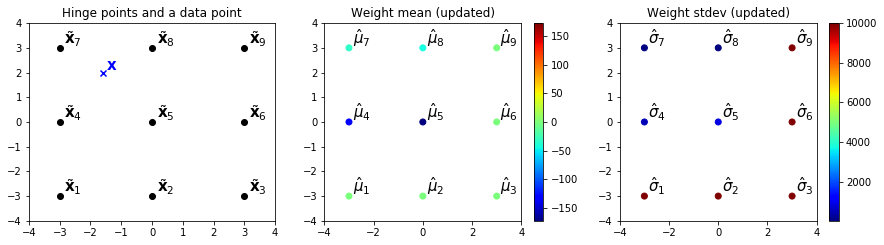

In [33]:
# Define xi vector
xi = np.ones(N)

# Iteratively learn mu, sig, and xi
for i in range(5):
    # E-step
    mu, sig = calcPosterior(Phi, y, xi, mu, sig)

    # M-step
    xi = np.sqrt(np.sum((Phi**2)*sig, axis=1) + (Phi.dot(mu.reshape(-1, 1))**2).ravel()) #simplify the brackets
    
# Plot
pl.figure(figsize=(15,8))
pl.subplot(231)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='x')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf{x}$', color='b', fontsize=15)
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points and a data point')
pl.xlim([-4,4]); pl.ylim([-4,4])

pl.subplot(232)
pl.scatter(grid[:,0], grid[:,1], c=mu, cmap='jet', vmin=-np.max(np.abs(mu)), vmax=np.max(np.abs(mu))); pl.colorbar()
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\hat{\mu}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Weight mean (updated)')
pl.xlim([-4,4]); pl.ylim([-4,4]);

pl.subplot(233)
pl.scatter(grid[:,0], grid[:,1], c=sig, cmap='jet'); pl.colorbar()
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\hat{\sigma}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Weight stdev (updated)')
pl.xlim([-4,4]); pl.ylim([-4,4]);

***Observations:***
1. Weights associated with hinge points that are closer to the unoccupied data point have lower mean values i.e. more likely to be free
2. The weight means are close to zero and the stdevs are very high in areas where there are no data (1, 2, 3, 6, and 9)

#### Step 4: Make predictions

Having run the for-loop for a sufficient number of iterations (practically, one or two iterations is sufficient), we now have estimates for weights $\mathbf{\hat{w}}$. That is we use $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ from the last iteration as $\mathbf{\hat{w}}$.

Let's say we want to know the probability the point $\mathbf{x}_*$ being occupied in the space.
\begin{split}
 p(y=1 | \mathbf{x}_*) &= \int \sigma \big( \mathbf{\hat{w}} \Phi^\top(\mathbf{x}_*) \big) p(\mathbf{\hat{w}}) \mathrm{d}\mathbf{w} \\
 &\approx \frac{1}{|\mathcal{\hat{W}}_q|} \sum_{\mathbf{\hat{w}}_q \in \mathcal{\hat{W}}_q} \sigma \big( \mathbf{\hat{w}}_q \Phi^\top(\mathbf{x}_*) \big),
\end{split}

where $\mathcal{\hat{W}}_q = \{ \mathbf{\hat{w}}_q \}$ are samples drawn from  $\hat{\mathbf{w}} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})$.

Since $\mathbf{x}_*$ can be any location in the space, we can build a *continuous occupancy map*.

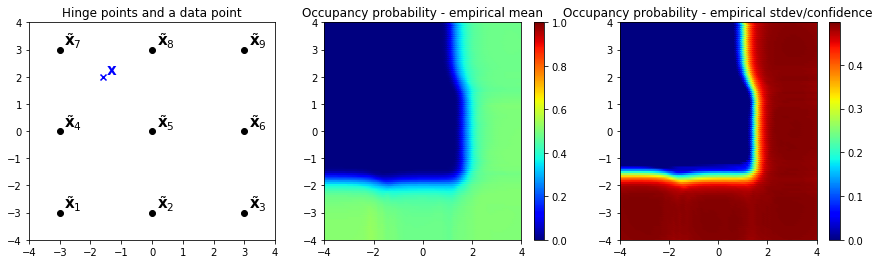

In [52]:
# Let's query 10000 points between (-4,4) in each direction
qxx, qyy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
qX = np.hstack((qxx.ravel().reshape(-1,1), qyy.ravel().reshape(-1,1)))
qPhi = rbf_kernel(qX, grid, gamma=0.5)

# Draw samples and estimate the 
qw = np.random.multivariate_normal(mu, np.diag(sig), 1000)
occ = sigmoid(qw.dot(qPhi.T))
occMean = np.mean(occ, axis=0)
occStdev = np.std(occ, axis=0)

# Plot
pl.figure(figsize=(15,4))
pl.subplot(131)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='x')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf{x}$', color='b', fontsize=15)
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points and a data point')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(132)
pl.scatter(qX[:,0], qX[:,1], c=occMean, cmap='jet', vmin=0, vmax=1)
pl.colorbar()
pl.title('Occupancy probability - empirical mean')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(133)
pl.scatter(qX[:,0], qX[:,1], c=occStdev, cmap='jet', vmin=0)
pl.colorbar()
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.title('Occupancy probability - empirical stdev/confidence');

***Observations:***
1. Areas closer to the datapoint are predicted as free (probability$=0$) and highly confident that these predictions are correct (low standard deviation)
2. Areas farther from the datapoint are predicted as unkown (probability$=0.5$) and less confident (high standard deviation)

Alternatively, as a faster approach, the Lapace approximation can be used instead of sampling from the $\hat{\mathbf{w}}$ distribution.

\begin{equation}
  p(y=1 | \mathbf{x}_*) = \sigma(\kappa.\mu_a),
\end{equation}

where,
\begin{equation}
 \mu_a = \mathbf{w} \Phi^\top(\mathbf{x}_*)
\end{equation}

\begin{equation}
 \kappa = \bigg( 1 + \frac{\pi}{8}  \big(\boldsymbol{\sigma}*\Phi(\mathbf{x}_*) \big) \Phi(\mathbf{x}_*)  \bigg)^{-1/2}
\end{equation}

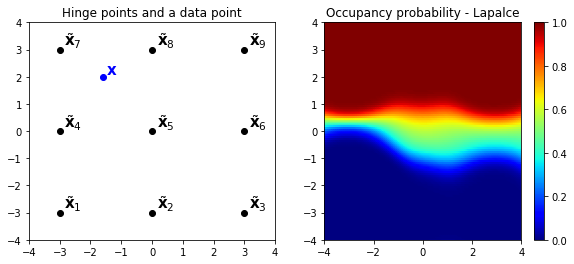

In [59]:
def predictLap(qPhi, mu, sig):
    mu_a = qPhi.dot(mu.reshape(-1, 1)).ravel()
    sig2_inv_a = np.sum((qPhi ** 2) * sig, axis=1)
    kappa = 1.0 / np.sqrt(1 + np.pi * sig2_inv_a / 8)
    return sigmoid(kappa*mu_a)
        
occMeanLap = predictLap(qPhi, mu, sig)

# Plot
pl.figure(figsize=(15,4))
pl.subplot(131)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X[:,0], X[:,1], c='b', marker='o')
pl.text(X[0,0]+0.1, X[0,1]+0.1, r'$\bf{x}$', color='b', fontsize=15)
for i in range(grid.shape[0]):
    pl.text(grid[i,0]+0.15, grid[i,1]+0.15, r'$\tilde{\bf{x}}$'+'$_{}$'.format(i+1), fontsize=15)
pl.title('Hinge points and a data point')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(132)
pl.scatter(qX[:,0], qX[:,1], c=occMeanLap, cmap='jet', vmin=0, vmax=1)
pl.colorbar()
pl.title('Occupancy probability - Lapalce')
pl.xlim([-4,4]); pl.ylim([-4,4]);

## 2. An example with multiple points

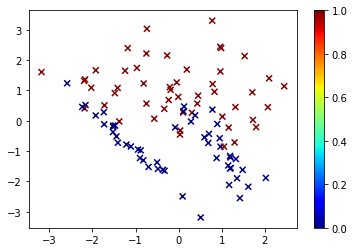

In [68]:
# Let's generate a dataset
X2, y2 = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2)
y2 = y2.ravel()
pl.scatter(X2[:,0], X2[:,1], c=y2, marker='x', cmap='jet')
pl.colorbar()

feature map size:  (100, 9)


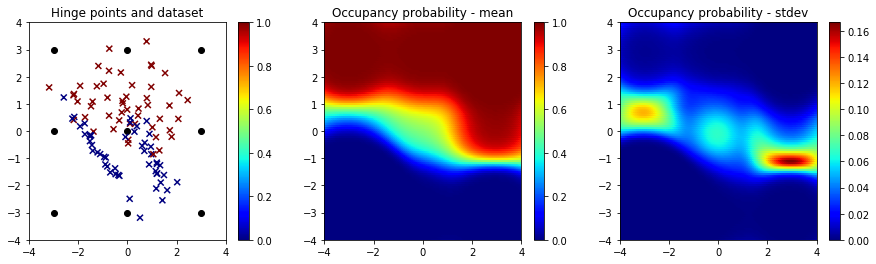

In [71]:
# Step 1 - define hinde points
xx, yy = np.meshgrid(np.linspace(-3, 3, 3), np.linspace(-3, 3, 3))
grid = np.hstack((xx.ravel().reshape(-1,1), yy.ravel().reshape(-1,1)))

# Step 2 - compute features
gamma = 0.5
Phi = rbf_kernel(X2, grid, gamma=gamma)
print("feature map size: ", Phi.shape)

# Step 3 - estimate the parameters
# Let's define the prior
N, D = Phi.shape[0], Phi.shape[1]
xi = np.ones(N)
mu = np.zeros(D)
sig = 10000*np.ones(D)

for i in range(3):
    # E-step
    mu, sig = calcPosterior(Phi, y2, xi, mu, sig)

    # M-step
    xi = np.sqrt(np.sum((Phi**2)*sig, axis=1) + (Phi.dot(mu.reshape(-1, 1))**2).ravel())

# Step 4 - predict
qxx, qyy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
qX = np.hstack((qxx.ravel().reshape(-1,1), qyy.ravel().reshape(-1,1)))
qPhi = rbf_kernel(qX, grid, gamma=gamma)
qw = np.random.multivariate_normal(mu, np.diag(sig), 1000)
occ = sigmoid(qw.dot(qPhi.T))
occMean = np.mean(occ, axis=0)
occStdev = np.std(occ, axis=0)

# Plot
pl.figure(figsize=(15,4))
pl.subplot(131)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X2[:,0], X2[:,1], c=y2, marker='x', cmap='jet')
pl.colorbar()
pl.title('Hinge points and dataset')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(132)
pl.scatter(qX[:,0], qX[:,1], c=occMean, cmap='jet', vmin=0, vmax=1)
pl.colorbar()
pl.title('Occupancy probability - mean')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(133)
pl.scatter(qX[:,0], qX[:,1], c=occStdev, cmap='jet', vmin=0)
pl.colorbar()
pl.title('Occupancy probability - stdev')
pl.xlim([-4,4]); pl.ylim([-4,4]);

Let's have more hinge points (36 instead if 9). Because the hinge points are closer to each other, we should also increase $\gamma$. Set the $\gamma$ values to 0.1, 0.5, 2, 5, and 15 and see the effect.

feature map size:  (100, 36)


/home/ransalu/RansVirtualEnvs/Main3.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


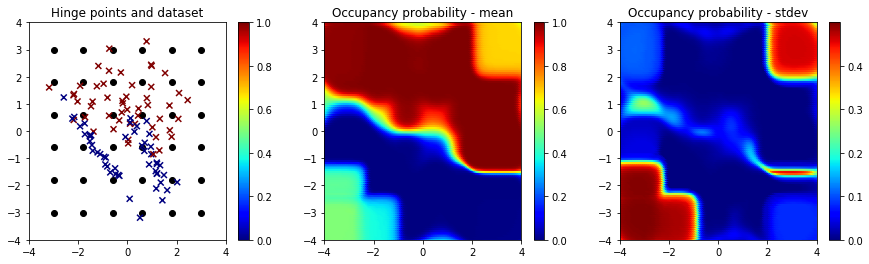

In [72]:
# Step 1 - define hinde points
xx, yy = np.meshgrid(np.linspace(-3, 3, 6), np.linspace(-3, 3, 6))
grid = np.hstack((xx.ravel().reshape(-1,1), yy.ravel().reshape(-1,1)))

# Step 2 - compute features
gamma = 2.5
Phi = rbf_kernel(X2, grid, gamma=gamma)
print("feature map size: ", Phi.shape)

# Step 3 - estimate the parameters
# Let's define the prior
N, D = Phi.shape[0], Phi.shape[1]
xi = np.ones(N)
mu = np.zeros(D)
sig = 100000*np.ones(D)

for i in range(3):
    # E-step
    mu, sig = calcPosterior(Phi, y2, xi, mu, sig)

    # M-step
    xi = np.sqrt(np.sum((Phi**2)*sig, axis=1) + (Phi.dot(mu.reshape(-1, 1))**2).ravel())

# Step 4 - predict
qxx, qyy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
qX = np.hstack((qxx.ravel().reshape(-1,1), qyy.ravel().reshape(-1,1)))
qPhi = rbf_kernel(qX, grid, gamma=gamma)
qw = np.random.multivariate_normal(mu, np.diag(sig), 1000)
occ = sigmoid(qw.dot(qPhi.T))
occMean = np.mean(occ, axis=0)
occStdev = np.std(occ, axis=0)

# Plot
pl.figure(figsize=(15,4))
pl.subplot(131)
pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X2[:,0], X2[:,1], c=y2, marker='x', cmap='jet')
pl.colorbar()
pl.title('Hinge points and dataset')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(132)
pl.scatter(qX[:,0], qX[:,1], c=occMean, cmap='jet', vmin=0, vmax=1)
pl.colorbar()
pl.title('Occupancy probability - mean')
pl.xlim([-4,4]); pl.ylim([-4,4])
pl.subplot(133)
pl.scatter(qX[:,0], qX[:,1], c=occStdev, cmap='jet', vmin=0)
pl.colorbar()
pl.title('Occupancy probability - stdev')
pl.xlim([-4,4]); pl.ylim([-4,4]);
pl.xlim([-4,4]); pl.ylim([-4,4]);

## 3. Points from a LIDAR

In a global coordinate system, we consider the robot is at $(x1_0,x2_0)$ and we obtained a LIDAR reflection at $(x1,x2)$. The LIDAR hit location belongs to class $y=1$ and the line-of-sight space between the robot and the LIDAR hit point are free. We randomly draw samples from this free space and label as $y=0$. To do this, we consider the parametric form of a line. 

$[x1_s,x2_s] = [x1_0, x2_0] + p.[x1_0-x1, x2_0-x2]$ where $p \in [0, 1) \sim {U}[0, 1-\alpha]$ with $\alpha \gtrapprox 0$, Here, $\alpha$ is a very small number to avoid overlapping free points from occupied points. The collection of $(x1_s,x2_s, y=0)$ points along side $(x1,x2, y=1)$ is the training dataset.

trainingData=
 [[ 0.90745844  1.09254156  0.        ]
 [ 0.89814228  1.10185772  0.        ]
 [-0.10790933  2.10790933  0.        ]
 [-0.39071695  2.39071695  0.        ]
 [-2.88499076  4.88499076  0.        ]
 [-3.          5.          1.        ]]


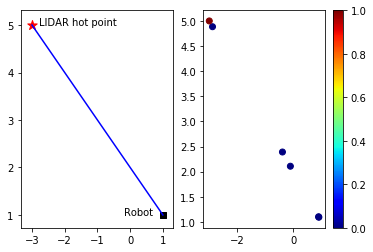

In [64]:
robotPos = np.array([[1,1]])
laserHitpoint = np.array([[-3,5]])

margin = 0.01
unoccupiedPointsPerMeter = 1
distance = np.sqrt(np.sum((laserHitpoint-robotPos)**2))
para = np.sort(np.random.random(np.int16(distance*unoccupiedPointsPerMeter)) * (1 - 2 * margin) + margin)[:,np.newaxis]  # TODO: Uniform[0.05, 0.95]
freePoints = robotPos + para * (laserHitpoint - robotPos) 
freePoints = np.hstack((freePoints, np.zeros(freePoints.shape[0]).reshape(-1,1)))
occPoint = np.hstack((laserHitpoint, np.array([[1]])))
trainingData = np.vstack((freePoints,occPoint))
print('trainingData=\n', trainingData)

pl.subplot(121)
pl.plot(np.concatenate((robotPos[:,0],laserHitpoint[:,0])), \
        np.concatenate((robotPos[:,1],laserHitpoint[:,1])), c='b')
pl.scatter(laserHitpoint[:,0], laserHitpoint[:,1], c='r', s=100, marker='*')
pl.text(laserHitpoint[:,0]+0.2, laserHitpoint[:,1], 'LIDAR hot point')
pl.scatter(robotPos[:,0], robotPos[:,1], c='k', marker='s')
pl.text(robotPos[:,0]-1.2, robotPos[:,1], 'Robot')
pl.subplot(122)
pl.scatter(trainingData[:,0], trainingData[:,1], c=trainingData[:,2], cmap='jet')
pl.colorbar()

In [65]:
#Let's define a function for this
def getTrainingData(data, robot_pos, max_laser_distance, unoccupied_points_per_meter=1, margin=0.01):
    distances = np.sqrt(np.sum((data-robot_pos)**2, axis=1))

    # parametric filling
    for n in range(len(distances)):
        dist = distances[n]
        laser_endpoint = data[n,:3]
        para = np.sort(np.random.random(np.int16(dist * unoccupied_points_per_meter)) * (1 - 2 * margin) + margin)[:,np.newaxis]  # TODO: Uniform[0.05, 0.95]
        points_scan_i = robot_pos + para * (laser_endpoint - robot_pos)  # y = <x0, y0, z0> + para <x, y, z>; para \in [0, 1]
        #print('points_scan_i', points_scan_i)

        if n == 0:  # first data point
            if dist >= max_laser_distance:  # there's no laser reflection
                points = points_scan_i
                labels = np.zeros((points_scan_i.shape[0], 1))
            else:  # append the arrays with laser end-point
                points = np.vstack((points_scan_i, laser_endpoint))
                labels = np.vstack((np.zeros((points_scan_i.shape[0], 1)), np.array([1])[:, np.newaxis]))
        else:
            if dist >= max_laser_distance:  # there's no laser reflection
                points = np.vstack((points, points_scan_i))
                labels = np.vstack((labels, np.zeros((points_scan_i.shape[0], 1))))
            else:  # append the arrays with laser end-point
                points = np.vstack((points, np.vstack((points_scan_i, laser_endpoint))))
                labels = np.vstack((labels, np.vstack((np.zeros((points_scan_i.shape[0], 1)), np.array([1])[:, np.newaxis]))))

    return np.hstack((points, labels))

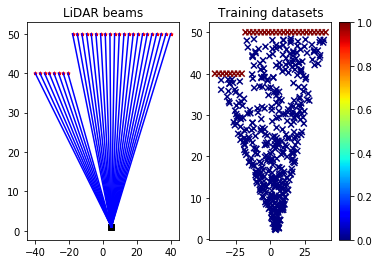

In [66]:
# Let's generate a toy dataset wit 30 LIDAR beams (note: this disregards circular geometry for simplicity)
nBeams = 30
robotPos = np.array([[5,1]])
laserHitpoints = np.hstack((np.linspace(-40,40, nBeams).reshape(-1,1), 50*np.ones((nBeams,1)) ) )
laserHitpoints[:8,1] = 40

# Get the training set
trainingData = getTrainingData(laserHitpoints, robotPos, 100, 0.3, 0.03)

# Plot
pl.subplot(121)
for i in range(nBeams):
    pl.plot(np.concatenate((robotPos[:,0],np.array([laserHitpoints[i,0]]))), \
            np.concatenate((robotPos[:,1],np.array([laserHitpoints[i,1]]))), c='b')
pl.scatter(laserHitpoints[:,0], laserHitpoints[:,1], c='r', s=10, marker='*')
pl.scatter(robotPos[:,0], robotPos[:,1], c='k', marker='s')
pl.title('LiDAR beams')
pl.subplot(122)
pl.scatter(trainingData[:,0], trainingData[:,1], c=trainingData[:,2], marker='x', cmap='jet')
pl.colorbar()
pl.title('Training datasets');

feature map size:  (487, 1800)


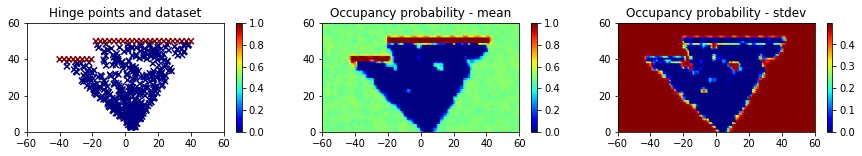

In [67]:
# Step 0 - data
X3, y3 = trainingData[:,:2], trainingData[:,2]

# Step 1 - define hinde points
xx, yy = np.meshgrid(np.linspace(-60, 60, 60), np.linspace(0, 60, 30))
grid = np.hstack((xx.ravel().reshape(-1,1), yy.ravel().reshape(-1,1)))

# Step 2 - compute features
gamma = 0.7
Phi = rbf_kernel(X3, grid, gamma=gamma)
print("feature map size: ", Phi.shape)

# Step 3 - estimate the parameters
# Let's define the prior
N, D = Phi.shape[0], Phi.shape[1]
epsilon = np.ones(N)
mu = np.zeros(D)
sig = 10000*np.ones(D)

for i in range(3):
    # E-step
    mu, sig = calcPosterior(Phi, y3, epsilon, mu, sig)

    # M-step
    epsilon = np.sqrt(np.sum((Phi**2)*sig, axis=1) + (Phi.dot(mu.reshape(-1, 1))**2).ravel())

# Step 4 - predict
qxx, qyy = np.meshgrid(np.linspace(-60, 60, 120), np.linspace(0, 60, 60))
qX = np.hstack((qxx.ravel().reshape(-1,1), qyy.ravel().reshape(-1,1)))
qPhi = rbf_kernel(qX, grid, gamma=gamma)
qw = np.random.multivariate_normal(mu, np.diag(sig), 1000)
occ = sigmoid(qw.dot(qPhi.T))
occMean = np.mean(occ, axis=0)
occStdev = np.std(occ, axis=0)

# Plot
pl.figure(figsize=(15,2))
pl.subplot(131)
#pl.scatter(grid[:,0], grid[:,1], c='k', marker='o')
pl.scatter(X3[:,0], X3[:,1], c=y3, marker='x', cmap='jet')
pl.colorbar()
pl.title('Hinge points and dataset')
pl.xlim([-60,60]); pl.ylim([0,60]);
pl.subplot(132)
pl.scatter(qX[:,0], qX[:,1], c=occMean, s=4, cmap='jet', vmin=0, vmax=1)
pl.colorbar()
pl.title('Occupancy probability - mean')
pl.xlim([-60,60]); pl.ylim([0,60]);
pl.subplot(133)
pl.scatter(qX[:,0], qX[:,1], c=occStdev,  s=4, cmap='jet', vmin=0)
pl.colorbar()
pl.title('Occupancy probability - stdev')
pl.xlim([-60,60]); pl.ylim([0,60]);

##### NOTE: Check the .py files for faster versions (numpy and pytorch).  It takes several milliseconds for each update. 

## 4. How to learn hinge locations and kernel parameters?

Practically, it is possible to fix the hinge points in a equi-spaced grid. It is also not difficult to heuristically (visual inspection or cross-validation) get a $\gamma$ value. However, to obtain the best quality map, it is also possible to lear them.


```
@inproceedings{senanayake2018automorphing,
  title={Automorphing Kernels for Nonstationarity in Mapping Unstructured Environments},
  author={Senanayake*, Ransalu and Tomkins*, Anthony and Ramos, Fabio},
  booktitle={Conference on Robot Learning (CoRL)},
  pages={--},
  year={2018}
}
```

paper: https://drive.google.com/file/d/13bKfYLKzqo5dmvWAAvPTdE05ccgLYiT9/view

code: https://github.com/MushroomHunting/autormorphing-kernels

video: https://www.youtube.com/watch?v=IirUlJS49Yw&feature=youtu.be


## 5. How to fuse data from multiple sources?

```
@inproceedings{zhi2019fusion,
  title={Continuous Occupancy Map Fusion with Fast Bayesian Hilbert Maps},
  author={Zhi, William and Ott, Lionel and Senanayake, Ransalu and Ramos, Fabio},
  booktitle={The International Conference on Robotics and Automation (ICRA)},
  pages={--},
  year={2019}
}
```